# Understanding Virality

*How does information and influence propagate on social networks?*

## First milestone: scaffolding and preliminary analysis of the data.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import findspark
findspark.init()

# Import and start a Spark session.
from pyspark.sql import *
from pyspark.sql.functions import *

spark = SparkSession.builder.getOrCreate()

We started by extracting information about hashtags from tweets for every month using `scripts/hashtags_insights.py`, and store all this information into `hashtag{xx}.parquet` files (with `{xx}` the number of the month, from `02` to `11` so far). Looking at `hashtag02.parquet`, we can see that we have extracted the number of occurences, minimum timestamp and maximum timestamp of $2737114$ hashtags for March 2017.

In [4]:
hashtags = spark.read.parquet('hashtag02.parquet')

In [5]:
hashtags.count()

2737114

To avoid memory issues, we limit ourselves to hashtags with more than 10 occurences in the month.

In [ ]:
hashtags_df = hashtags.where(col('count') > 10).toPandas()

In [7]:
hashtags_df.head()

,tag,count,min_timestamp,max_timestamp
0,Season9,13,1485997586664,1487816542662
1,NBA,7832,1485934976663,1488351071663
2,NadineLustre,262466,1485942989659,1488351593657
3,العسكريين,31,1486018308658,1487696188658
4,Girl,249,1485937286663,1488347704663


### Analysis of the occurence of hashtags.

We first wanted to understand the distribution of the number of occurences of the hashtags we extracted for that month.

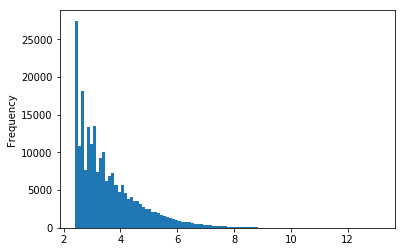

In [8]:
hashtags_df['count'].apply(np.log).plot.hist(bins=100)

As we can see from the graph above, the majority of hashtags are used only a few times (between $1$ and $10000$ times), while there are much fewer hashtags which appear more than $10000$ times.

In [9]:
hashtags.sort('count', ascending=False).head(20)

[Row(tag='KCAPinoyStar', count=495924, min_timestamp=1486279800659, max_timestamp=1488351594662),
 Row(tag='iHeartAwards', count=457805, min_timestamp=1485934219659, max_timestamp=1488351563659),
 Row(tag='BestFanArmy', count=272830, min_timestamp=1485934214659, max_timestamp=1488351561663),
 Row(tag='NadineLustre', count=262466, min_timestamp=1485942989659, max_timestamp=1488351593657),
 Row(tag='LizaSoberano', count=217898, min_timestamp=1486012485658, max_timestamp=1488351594662),
 Row(tag='VideoLove', count=178661, min_timestamp=1486418799659, max_timestamp=1488351588663),
 Row(tag='KCAEstrellaLatina', count=141810, min_timestamp=1486057899663, max_timestamp=1488351562662),
 Row(tag='OneDBestFans', count=117440, min_timestamp=1485934730659, max_timestamp=1488303599657),
 Row(tag='izmirescort', count=111827, min_timestamp=1485934481665, max_timestamp=1488350222660),
 Row(tag='사설토토사이트추천', count=107461, min_timestamp=1485934200657, max_timestamp=1488351553665),
 Row(tag='방탄소년단', count

By looking at the most used hashtags in March 2017, we can see that most of them revolve around the iHeartRadio Music Awards (`#iHeartAwards`, `#BestFanArmy`, `#OneDBestFans`, `#CamilaBestFans`, `#BTS`, `#BestMusicVideo`, `#BestCover`, etc.), or other media events (the `#Oscars` for instance). 

An metric that we thought would be interesting to explore is the hashtag "spread", i.e. the time difference between the first and last time it was used that month (in milliseconds).

In [11]:
hashtags_df['timediff'] = hashtags_df.max_timestamp - hashtags_df.min_timestamp

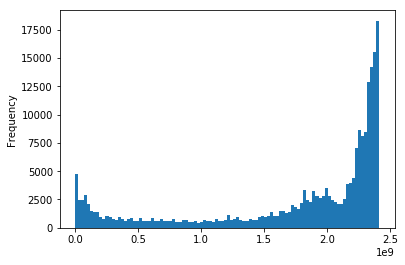

In [14]:
hashtags_df.timediff.plot.hist(bins=100)

By looking at a histogram of the hashtag spreads for March 2017, we can see two interesting trends:

- The vast majority of hashtags was used throughout the month or almost. This is the case with recurring hashtags (such as `#TBT`, `#Quran` or `#Sexy`), or with hashtags that correspond to events taking place over several months (e.g. `#MeToo`).
- A few hashtags are also very localized in time, with less than $0.2 \dot 10^9$ milliseconds of spread, i.e. less than two days. This is the case, for instance, of hashtags such as those related to the TV events, which usually start trending a few hours before the beginning of the broadcast, and loose traction the day after.

By restricting this histogram to the $1000$ and $100$ most used hashtags over the month, we can see however almost all most-used hashtags are spread over the whole month. This begs the question, however, of our choice of metric: the spread is really sensitive to time outliers, so even though 90% of the tweets using `#iHeartAwards` happened the day of the event and the day after, we still have a spread of almost the entire month because some people used the hashtag at the end of the month to refer back to the event.

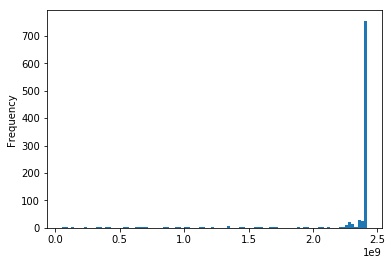

In [30]:
top = hashtags_df.nlargest(1000, 'count')
top.timediff.plot.hist(bins=100)

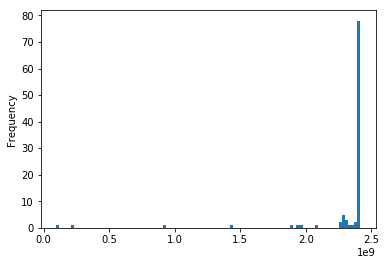

In [32]:
top = hashtags_df.nlargest(100, 'count')
top.timediff.plot.hist(bins=100)

To gain insight about the hashtags with a large spread, we printed out the spread of most occuring hashtags in decreasing order.

In [33]:
top = hashtags_df.nlargest(1000, 'count')
top.sort_values(by='timediff', ascending=False)

,tag,count,min_timestamp,max_timestamp,timediff
26718,Quran,27165,1485934204661,1488351597663,2417393002
55275,GOT7,78695,1485934203661,1488351594660,2417390999
7977,갓세븐,44691,1485934203661,1488351594660,2417390999
89570,진영,10768,1485934203661,1488351592658,2417388997
214642,quote,25711,1485934204661,1488351585665,2417381004
43355,คลื่นชีวิต,14912,1485934201657,1488351578659,2417377002
211491,메이저놀이터추천,4886,1485934200657,1488351570664,2417370007
70859,Pakistan,3870,1485934235664,1488351599658,2417363994
13482,porn,17599,1485934218666,1488351582659,2417363993
101734,Sexy,2950,1485934231662,1488351592664,2417361002


As we predicted, the popular hashtags with the largest spread are mostly general topics, such as `#Quran`, `#Pakistan`, `#porn` or `#Sexy`; while some of those with the smallest spread are linked to overday or overnight events (e.g. TV broadcasts), such as `#DestinedToBeYoursWorldPremiere` or `#MyExAndWhysWorldwideHit`.

### Isolating a few popular hashtags to investigate.

Besides our general analysis of the occurences and spread of hashtags over 2017, we thought we would benefit from finer-grained insight about a few well-chosen hashtags. The first one we decided to analyse is `#BalanceTonPorc`, as it is a textbook case of "organic spreading" of a hashtag in the year 2017. We compiled all the tweets regarding that hashtags into a parquet file, and started to analyse them.

## First analysis of balance ton porc

We consider tweets having hashtag #balancetonporc posted during the month of October.

In [4]:
tweets = spark.read.parquet('sample_balancetonporc_10.parquet')

In [5]:
tweets.count()

2569

In [12]:
timestamps = tweets.select(col('timestamp_ms'))
timestamps_pd = timestamps.toPandas()

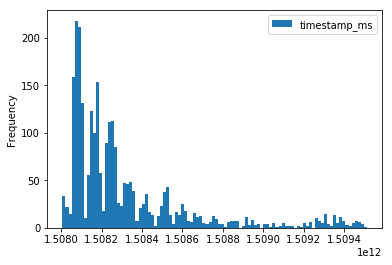

In [13]:
timestamps_pd.plot.hist(bins=100)

On the above plot we can see several peak. These huge decrease can be explained by two reasons:
- `#balancetonporc` was localized in France, so on one timezone
- During the nights a person is less likely to tweet

However, we can see what seems like a power law: at first the number of tweets is high and then decrease progressively. It might also be interesting to extract the data for the month of september.

We are also thinking of analyzing other metrics:
- Number of retweets and likes according to the time
- "Profile" of the person twitting. Is there someone with a huge number of followers who tweeted right before a peak?
- Geographicall progression of the activity. Has the activity started on a specific place and then spread to other part of France? Or was the starting point distributed in the country?